In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import json
from scipy.stats import weibull_min
import autograd.numpy as np
import pandas as pd
plt.style.use('seaborn')
%matplotlib inline

from lifelines import WeibullFitter, KaplanMeierFitter, ExponentialFitter, NelsonAalenFitter
from lifelines.fitters import ParametricUnivariateFitter
from lifelines.utils import restricted_mean_survival_time as rmst, qth_survival_time as qst
from scipy.stats import kstest, cramervonmises, uniform

#custom
from scripts.utils import convert_to_lifetimes

In [2]:
data = json.load(open('data/data.json', 'r'))

In [3]:
data.keys()

dict_keys(['Curcumin control', 'Curcumin experiment', 'Berberine control', 'Berberine experiment', 'Sirtuin control', 'Sirtuin experiment', 'Rapamycin control', 'Rapamycin experiment', 'Keto control', 'Rapamycin2 control', 'Diet control', 'AKG control', 'Frailty control', 'Chinese control', 'Circad control'])

In [4]:
alter_names = ['- curcumin', '+ curcumin', '- berberine', '+ berberine', '- SIRT6', '+ SIRT6',
               '- rapamycin', '+ rapamycin', 'PMID: 28877458', 'PMID: 24409289', 'PMID: 28877457',
               'PMID: 32877690', 'PMID: 32934233', 'PMID: 20370440', 'PMID: 35511946']

In [5]:
#target_cdf = lambda x: 1 - np.exp(-(x / l)**k)

class GompertzFitter(ParametricUnivariateFitter):
    # this parameterization is slightly different than wikipedia.
    _fitted_parameter_names = ['nu_', 'b_']
    def __init__(self, times):
        super(GompertzFitter, self).__init__()
        self.Tmax = np.max(times)
    def _cumulative_hazard(self, params, times):
        nu_, b_ = params
        return nu_ * (np.expm1(times * b_/self.Tmax))
    

# ggf = GompertzFitter(T)
# ggf.fit(T)
# ggf.print_summary()
# ax = ggf.plot_cumulative_hazard(figsize=(8,5))
# ax = NelsonAalenFitter().fit(T).plot(ax=ax, ci_show=False)

In [6]:
def compute_plausibility_score(T, E=None, method='ks', target='weibull', return_all=False):
    # define target distribution
    if target == 'weibull':
        wf = WeibullFitter().fit(T, E)
        l, k = wf.lambda_, wf.rho_
        target_cdf = lambda x: 1 - np.exp(-(x / l)**k)
    elif target == 'gompertz':
        ggf = GompertzFitter(T).fit(T)
        A, B = ggf.nu_, ggf.b_
        Tmax = np.max(T)
        target_cdf = lambda x: 1 - np.exp(-A * np.expm1(x * B / Tmax))
    else:
        raise NotImplementedError
    # define anti-distribution
    a, b = np.min(T), np.max(T) #uniform boundaries 
    anti_cdf = lambda x: np.minimum((x - a) / (b - a), 1.)
    # define anti-distribution
    # exp = ExponentialFitter().fit(T, E)
    # lmb = exp.lambda_
    # anti_cdf = lambda x: 1 - np.exp(-(x / lmb))

    # test with some `method`
    if method=='ks':
        _, pval1 = kstest(T, target_cdf)
        _, pval2 = kstest(T, anti_cdf)
    elif method=='cramer':
        tmp1 = cramervonmises(T, target_cdf)
        _, pval1 = tmp1.statistic, tmp1.pvalue
        tmp2 = cramervonmises(T, anti_cdf)
        _, pval2 = tmp2.statistic, tmp2.pvalue
    pl = np.log10(pval1 / pval2)
    if return_all:
        return pl, pval1, pval2
    else:
        return pl

In [7]:
#get weibull parameters for all data
loc, scale = [], []
loc2, scale2 = [], []
for i, (name, experiment) in enumerate(data.items()):
    x = experiment['x']
    y = experiment['y']
    n = experiment['n']
    T = convert_to_lifetimes(x, y, n) 

    wf = WeibullFitter().fit(T)
    l, k = wf.lambda_, wf.rho_
    loc.append(l)
    scale.append(k) 

    ggf = GompertzFitter(T).fit(T)
    A, B = ggf.nu_, ggf.b_
    loc2.append(A)
    scale2.append(B)
wp = pd.DataFrame({'Loc':loc, 'Scale':scale}, index=data.keys())
gp = pd.DataFrame({'Loc':loc2, 'Scale':scale2}, index=data.keys())

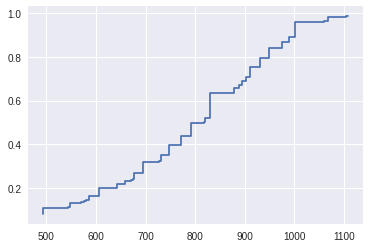

(array([16., 11.,  4.,  4.,  4.,  1.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.01151878, 0.02303755, 0.03455633, 0.04607511,
        0.05759388, 0.06911266, 0.08063143, 0.09215021, 0.10366899,
        0.11518776]),
 <BarContainer object of 10 artists>)

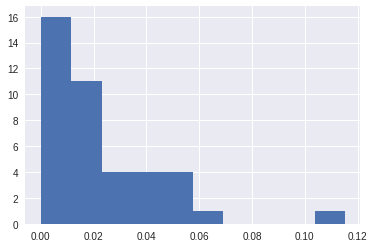

In [8]:
f = ggf.cumulative_density_at_times(np.array(T))
plt.step(T, f)
plt.show()

plt.hist(np.diff(f))

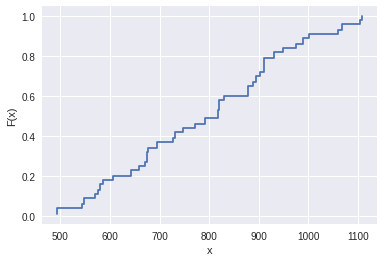

In [9]:
# Define a function to generate a random sample from the EDF
def generate_sample_edf(sample, n=100):
    # Compute the empirical distribution function (EDF)
    sample_sorted = np.sort(sample)
    sample_size = len(sample_sorted)
    y = np.arange(1, sample_size + 1) / sample_size
    #rand_num = np.random.uniform(0, 1, size=n)
    rand_num = np.linspace(0, 1, n)
    index = np.searchsorted(y, rand_num)
    return sample_sorted[index]

# Use the function to generate a random sample from the EDF
n_new = 100
new_sample = generate_sample_edf(T, n_new)
new_sample_sorted = np.sort(new_sample)
y_new = np.arange(1, n_new+1) / n_new

# Plot the EDF
plt.step(new_sample_sorted, y_new)
plt.xlabel('x')
plt.ylabel('F(x)')
plt.show()


(array([ 2.,  0.,  2.,  3., 10., 11., 20., 29., 18.,  5.]),
 array([ 242.27449262,  334.39962898,  426.52476534,  518.6499017 ,
         610.77503805,  702.90017441,  795.02531077,  887.15044713,
         979.27558349, 1071.40071984, 1163.5258562 ]),
 <BarContainer object of 10 artists>)

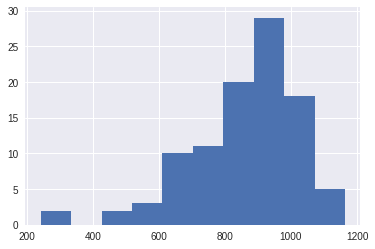

In [10]:
#generate gompertz sample
A = 0.000608
B = 8.8
n = 100
Tmax = 1100

def generate_gompertz_sample(A, B, Tmax, n=100):
    u = np.random.uniform(0, 1, n)
    x = Tmax / B * np.log(1 - np.log(1 - u) / A)
    return x

plt.hist(generate_gompertz_sample(A, B, Tmax))

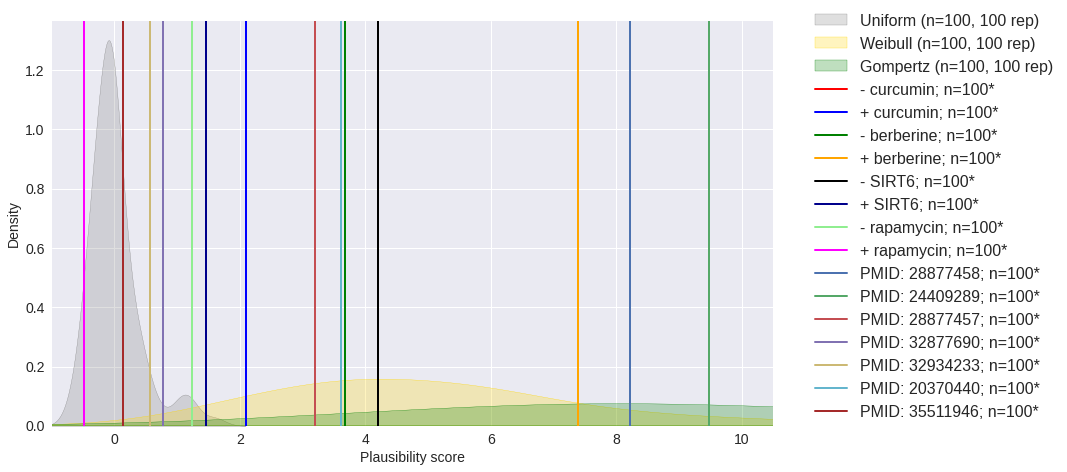

In [11]:
method = 'ks'
target = 'gompertz'
rep = 100
oversampling = True
plauf = []
plaut = []
plaut2 = []
for _ in range(rep):
    T = np.random.uniform(1, wp.Loc.mean(), 100)
    # T = np.random.exponential(100., 100)
    pl_f = compute_plausibility_score(T, E=None, method=method, target=target)
    plauf.append(pl_f)

    T = wp.Loc.mean()* np.random.weibull(wp.Scale.mean(), 100)
    pl_t = compute_plausibility_score(T, E=None, method=method, target=target)
    plaut.append(pl_t)

    T = generate_gompertz_sample(gp.Loc.mean(), gp.Scale.mean(), 900, n=100)
    pl_t2 = compute_plausibility_score(T, E=None, method=method, target=target)
    plaut2.append(pl_t2)
    

plt.figure(figsize=(15, 7))
sns.kdeplot(plauf, label = f'Uniform (n=100, {rep} rep)', color='grey', shade=True)
sns.kdeplot(plaut, label = f'Weibull (n=100, {rep} rep)', color='gold', shade=True)
sns.kdeplot(plaut2, label = f'Gompertz (n=100, {rep} rep)', color='green', shade=True)

colors = ['r', 'b', 'g', 'orange', 'black', 'darkblue', 'lightgreen', 'magenta', 
          '#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD', 'brown', 'cyan']
plau = []
pvals = []
for i, (name, experiment) in enumerate(data.items()):
    x = experiment['x']
    y = experiment['y']
    n = experiment['n']
    T = convert_to_lifetimes(x, y, n) 
    if oversampling:
        T = generate_sample_edf(T, n=100)
    pl, pval1, pval2 = compute_plausibility_score(T, E=None, method=method, target=target, return_all=True)
    pvals.append((pval1, pval2, pl)) #target, alt, ratio
    plau.append(round(pl, 2))
    #plt.axvline(pl, label=alter_names[i] + f'; n={n}', color=colors[i], lw=2)
    plt.axvline(pl, label=alter_names[i] + f'; n=100*', color=colors[i], lw=2)

plt.legend(loc=[1.05, 0.0], fontsize=16);
plt.xlim([-1, 10.5])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Plausibility score', fontsize=14);
plt.ylabel('Density', fontsize=14);
plt.tight_layout()
plt.savefig('plausibility_plot.pdf', dpi=300)  

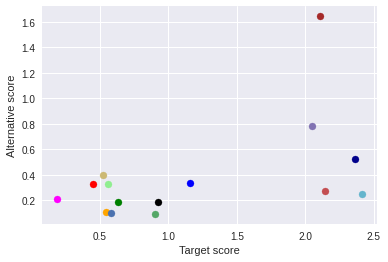

In [12]:
pv = pd.DataFrame(pvals)

for i,c in zip(range(len(pv)), colors): 
    plt.scatter(1/-np.log10(pv.iloc[i, 0]), 1/-np.log10(pv.iloc[i, 1]), c=c)
plt.xlabel('Target score')
plt.ylabel('Alternative score')
plt.show()

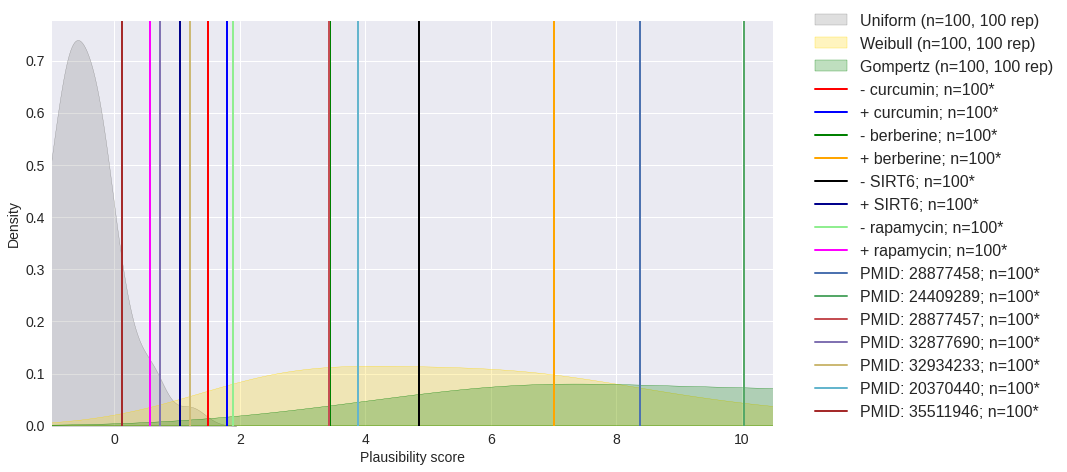

In [13]:
method = 'ks'
target = 'weibull'
rep = 100
oversampling = True
plauf = []
plaut = []
plaut2 = []
for _ in range(rep):
    T = np.random.uniform(1, wp.Loc.mean(), 100)
    # T = np.random.exponential(100., 100)
    pl_f = compute_plausibility_score(T, E=None, method=method, target=target)
    plauf.append(pl_f)

    T = wp.Loc.mean()* np.random.weibull(wp.Scale.mean(), 100)
    pl_t = compute_plausibility_score(T, E=None, method=method, target=target)
    plaut.append(pl_t)

    T = generate_gompertz_sample(gp.Loc.mean(), gp.Scale.mean(), 1000, n=100)
    pl_t2 = compute_plausibility_score(T, E=None, method=method, target=target)
    plaut2.append(pl_t2)
    

plt.figure(figsize=(15, 7))
sns.kdeplot(plauf, label = f'Uniform (n=100, {rep} rep)', color='grey', shade=True)
sns.kdeplot(plaut, label = f'Weibull (n=100, {rep} rep)', color='gold', shade=True)
sns.kdeplot(plaut2, label = f'Gompertz (n=100, {rep} rep)', color='green', shade=True)

colors = ['r', 'b', 'g', 'orange', 'black', 'darkblue', 'lightgreen', 'magenta', 
          '#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD', 'brown', 'cyan']
plau = []
for i, (name, experiment) in enumerate(data.items()):
    x = experiment['x']
    y = experiment['y']
    n = experiment['n']
    T = convert_to_lifetimes(x, y, n) 
    if oversampling:
        T = generate_sample_edf(T, n=100)
    pl = compute_plausibility_score(T, E=None, method=method, target=target)
    plau.append(round(pl, 2))
    #plt.axvline(pl, label=alter_names[i] + f'; n={n}', color=colors[i], lw=2)
    plt.axvline(pl, label=alter_names[i] + f'; n=100*', color=colors[i], lw=2)

plt.legend(loc=[1.05, 0.0], fontsize=16);
plt.xlim([-1, 10.5])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Plausibility score', fontsize=14);
plt.ylabel('Density', fontsize=14);
plt.tight_layout()
plt.savefig('plausibility_plot.pdf', dpi=300)  

In [14]:
plau

[1.49,
 1.79,
 3.44,
 7.02,
 4.85,
 1.04,
 1.9,
 0.57,
 8.39,
 10.04,
 3.42,
 0.72,
 1.2,
 3.88,
 0.13]

In [15]:
#build descriptive statistics
df = pd.DataFrame({"Plausibility":plau}, index=alter_names)
df['n'] = [v['n'] for v in data.values()]

mst = []
m95 = []
m50 = []
m05 = []
for i, (name, experiment) in enumerate(data.items()):
    x = experiment['x']
    y = experiment['y']
    n = experiment['n']
    T = convert_to_lifetimes(x, y, n) 
    kmf = KaplanMeierFitter().fit(T)

    mst.append(int(rmst(kmf, 1500)))
    m95.append(int(qst(0.95, kmf)))
    m50.append(int(qst(0.50, kmf)))
    m05.append(int(qst(0.05, kmf)))


df['Mean Surv Time'] = mst
df['5% Surv Time'] = m05
df['Median Surv Time'] = m50
df['95% Surv Time'] = m95

df.sort_values('Plausibility', ascending=False)

,Plausibility,n,Mean Surv Time,5% Surv Time,Median Surv Time,95% Surv Time
PMID: 24409289,10.04,40,815,1020,804,558
PMID: 28877458,8.39,61,879,1088,901,474
+ berberine,7.02,22,661,755,693,527
- SIRT6,4.85,52,753,1051,745,392
PMID: 20370440,3.88,54,769,1006,783,445
- berberine,3.44,22,605,709,598,446
PMID: 28877457,3.42,43,903,1103,884,696
- rapamycin,1.90,18,938,1234,927,679
+ curcumin,1.79,50,882,1033,882,640
- curcumin,1.49,50,830,1033,823,580


In [16]:
data.keys()

dict_keys(['Curcumin control', 'Curcumin experiment', 'Berberine control', 'Berberine experiment', 'Sirtuin control', 'Sirtuin experiment', 'Rapamycin control', 'Rapamycin experiment', 'Keto control', 'Rapamycin2 control', 'Diet control', 'AKG control', 'Frailty control', 'Chinese control', 'Circad control'])

(400.0, 1500.0)

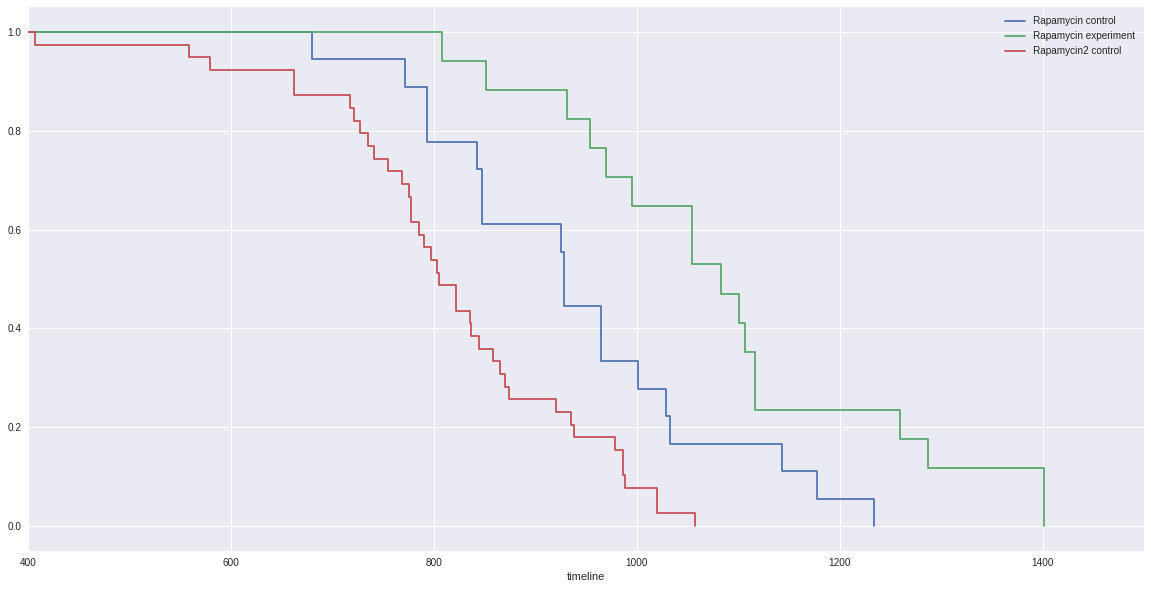

In [17]:
plt.figure(figsize=(20,10))
for i, (name, experiment) in enumerate(data.items()):
    if "Rapamycin" not in name:
        continue
    x = experiment['x']
    y = experiment['y']
    n = experiment['n']
    T = convert_to_lifetimes(x, y, n) 

    km = KaplanMeierFitter().fit(T,)
    ax = km.plot_survival_function(label=name, ci_show=False)
ax.set_xlim([400, 1500])

In [18]:
data.keys()

dict_keys(['Curcumin control', 'Curcumin experiment', 'Berberine control', 'Berberine experiment', 'Sirtuin control', 'Sirtuin experiment', 'Rapamycin control', 'Rapamycin experiment', 'Keto control', 'Rapamycin2 control', 'Diet control', 'AKG control', 'Frailty control', 'Chinese control', 'Circad control'])

['extra controls', '+ rapamycin; $P$=0.11', '- rapamycin; $P$=0.31', '+ berberine; $P$=1.68', '- berberine; $P$=0.73', '+ SIRT6; $P$=0.52', '- SIRT6; $P$=2.5', '+ curcumin; $P$=0.9', '- curcumin; $P$=0.75']


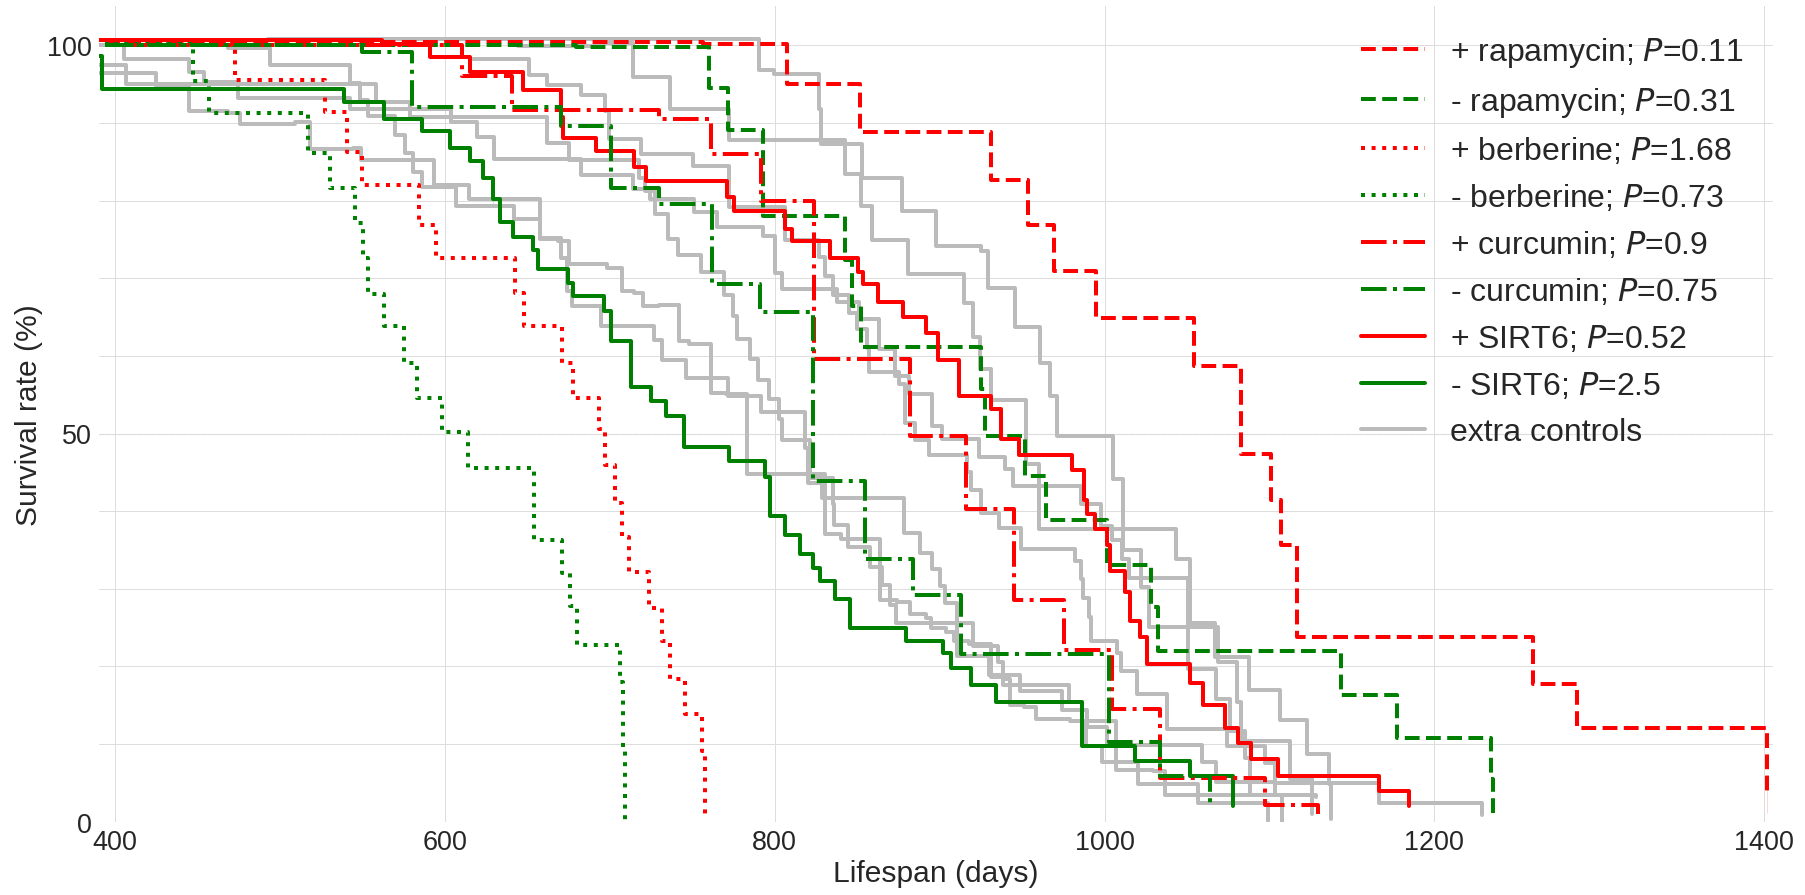

In [19]:
plt.style.use('seaborn')
def prepare_plot(title='Title'):
  fig, ax = plt.subplots(figsize=(30,15))
  #sns.set(font_scale=1.3, rc={'axes.facecolor':'w', 'figure.facecolor':'#eee'}) #, rc={'axes.facecolor':'#eee'}, 'figure.facecolor':'cornflowerblue'
  sns.set_style("whitegrid")
  sns.set_context("paper", font_scale=3.1)
  ax.axhline(50, ls='--', color='#ddd')
  ax.set_title(title,fontsize=21, y=1.05)
  ax.set_xlabel("Lifespan (days)",fontsize=30)
  ax.set_ylabel("Survival rate (%)",fontsize=30)
  return fig, ax

def prepare_data(data):
  data = data.splitlines()
  return np.array(data, dtype=float)

def plausibility_pipe(experiment):
    x = experiment['x']
    y = experiment['y']
    n = experiment['n']
    T = convert_to_lifetimes(x, y, n) 
    pl = compute_plausibility_score(T, E=None, method='ks')
    return pl
    
# with sns.axes_style("whitegrid"):
with sns.axes_style("whitegrid", {"grid.color" : "#ddd"}):
  fig, ax = prepare_plot(title='')
  ax.margins(y=-0.004)
  plt.xlim([390, 1405])
  plt.ylim(bottom=90, top=105)
  ax.set_yticks(range(0, 101, 10))
  ax.tick_params(axis='both', which='major', labelsize=27)

  for i in range(4):
    ax.yaxis.get_ticklabels()[1].set_visible(False)
  for i in range(4):
    ax.yaxis.get_ticklabels()[2].set_visible(False)

  
  ax = sns.lineplot(data=data['Keto control'], y='y', x='x', color='#bbb', drawstyle='steps-post', linewidth = 4)         # + label= 'control n=61 PMID: 28877458'
  ax3 = sns.lineplot(data=data['Diet control'], y='y', x='x', color='#bbb', drawstyle='steps-post', linewidth = 4)         # + , label= 'control n=43 PMID: 28877457'
  ax4 = sns.lineplot(data=data['Frailty control'], y='y', x='x', color='#bbb', drawstyle='steps-post', linewidth = 4)       # , label= 'control n=24 PMID: 32934233'
  ax5 = sns.lineplot(data=data['AKG control'], y='y', x='x', color='#bbb', drawstyle='steps-post', linewidth = 4)                   # , label= 'control n=24 PMID: 32877690'
  ax6 = sns.lineplot(data=data['Rapamycin2 control'], y='y', x='x', color='#bbb', drawstyle='steps-post', linewidth = 4)        # , label= 'control n=40 PMID: 24409289'
  ax7 = sns.lineplot(data=data['Circad control'], y='y', x='x', color='#bbb', drawstyle='steps-post', linewidth = 4)                # + , label= 'control n=43 PMID: 35511946'
  ax8 = sns.lineplot(data=data['Chinese control'], y='y', x='x', color='#bbb', label= 'extra controls', drawstyle='steps-post', linewidth = 4)               # + control n=54 PMID: 20370440

  p = round(plausibility_pipe(data['Rapamycin experiment']), 2)
  ax1= sns.lineplot(data=data['Rapamycin experiment'], y='y', x='x', color='r', 
                    label= '+ rapamycin' + f'; $P$={p}', ls='--', drawstyle='steps-post', linewidth = 4)                         # + 8 mg/kg/day i.p. rapamycin n=17
  
  p = round(plausibility_pipe(data['Rapamycin control']), 2)                    
  ax0= sns.lineplot(data=data['Rapamycin control'], y='y', x='x', color='g', 
                    label= '- rapamycin' + f'; $P$={p}', drawstyle='steps-post', ls='--', linewidth = 4)                   # + control n=18
  
  p = round(plausibility_pipe(data['Berberine experiment']), 2)
  ax21= sns.lineplot(data=data['Berberine experiment'], y='y', x='x', color='r', 
                    label= '+ berberine' + f'; $P$={p}', ls=':', drawstyle='steps-post', linewidth = 4, ci=95)  # + 50 mg/kg Berberine n=22
  
  p = round(plausibility_pipe(data['Berberine control']), 2)
  ax20= sns.lineplot(data=data['Berberine control'], y='y', x='x', color='g', 
                    label= '- berberine' + f'; $P$={p}', drawstyle='steps-post', ls=':', linewidth = 4)                         # +  control n=22
  
  p = round(plausibility_pipe(data['Sirtuin experiment']), 2)
  ax11= sns.lineplot(data=data['Sirtuin experiment'], y='y', x='x', color='r', 
                    label= '+ SIRT6' + f'; $P$={p}', drawstyle='steps-post', linewidth = 4)                    # + SIRT6 overexpression n=51
  
  p = round(plausibility_pipe(data['Sirtuin control']), 2)
  ax10= sns.lineplot(data=data['Sirtuin control'], y='y', x='x', color='g', 
                    label= '- SIRT6' + f'; $P$={p}', drawstyle='steps-post', linewidth = 4)                               # + SIRT6 control n=52
  
  p = round(plausibility_pipe(data['Curcumin experiment']), 2)
  ax12= sns.lineplot(data=data['Curcumin experiment'], y='y', x='x', color='r', ls='-.', 
                    label= '+ curcumin' + f'; $P$={p}', drawstyle='steps-post', linewidth = 4)                    # + SIRT6 overexpression n=51
  
  p = round(plausibility_pipe(data['Curcumin control']), 2)
  ax13= sns.lineplot(data=data['Curcumin control'], y='y', x='x', color='g', ls='-.', 
                    label= '- curcumin' + f'; $P$={p}', drawstyle='steps-post', linewidth = 4)                               # + SIRT6 control n=52

  # plt.legend(loc='lower left')
  handles, labels = ax.get_legend_handles_labels()
  print(labels)
  order = [1, 2, 3, 4, 7, 8, 5, 6, 0]
  plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=32)

  plt.savefig('line_plot.pdf', dpi=300)  


# спасибо .. замечания по картинке. 
# + 1. наверное не надо на главной картинке помечать контроли отдельно, не о них речь идет. 
#     Давайте сделаем две картинки, одну в Supplement где отрисованы "серые контроли контролей" каждый своим цветом или штрихом и помечены PMID. 
# +   А в Этой главной и единственой картинке пометим все их серым одинаково.  Серы если можно потемнее ...  и просто обзовем их "extra control" пока. 
# + 2. не надо начинать Lifespan с Нуля. мертвое пространство на графике. можно где то с 500 (?) дней. 
# + 3. по оси Y сличком много меток и мелковато, важно чтоб был 100%,  50%  и 0%. 
# + 4. количество мышей можно тоже оставить для подписи к картинке, легенду хочу сделать короткую и крупно хорошо видную.  
# 5.  как то я не обращал внимание раньше на ступенку в Рапамицине, и в контролях и в красной ... у нас по этим мышам только одна статья с рапомицином ? как то мало там зверей ... 17 + 18.   Ну если нет больше будем с этими двигаться. 
# + 6. дозу тоже можно оставить для подписи и убрать из легенды.   Может  все что надо в легенде это " + SIRT6, - SIRT6, + barb, - barb, + rapa, - rapa, extras"

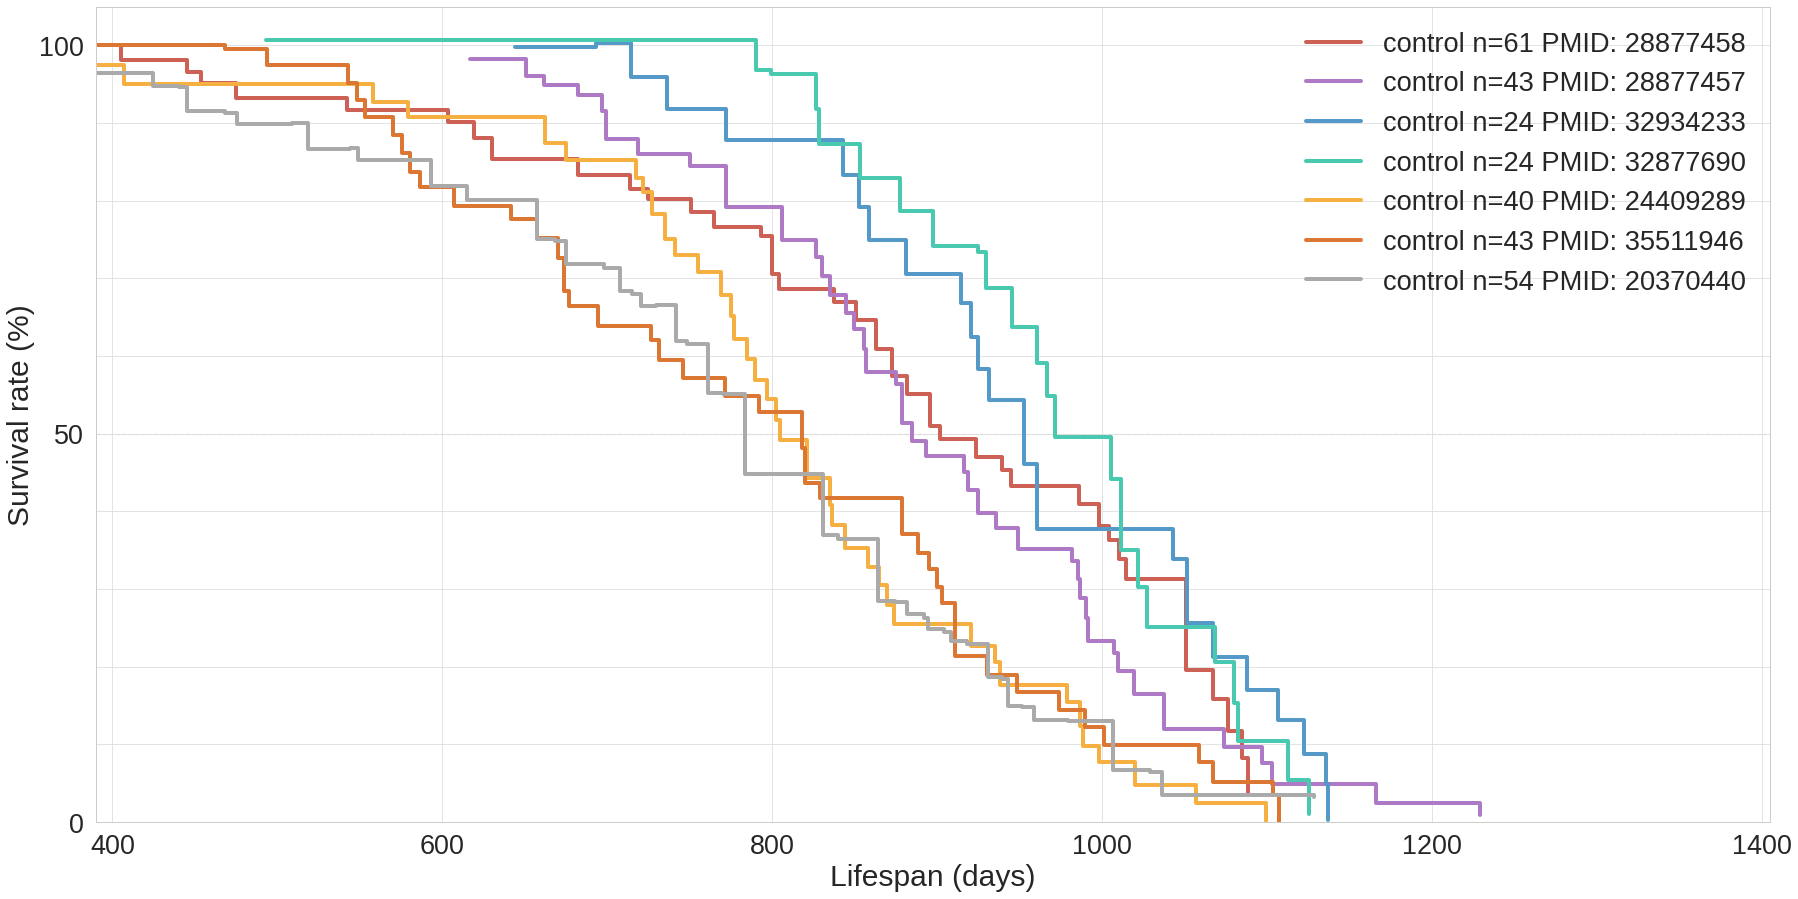

In [20]:


# with sns.axes_style("whitegrid"):
with sns.axes_style("whitegrid", {"grid.color" : "#ddd"}):
  fig, ax = prepare_plot(title='')
  ax.margins(y=-0.004)
  plt.xlim([390, 1405])
  plt.ylim(bottom=90, top=105)
  ax.set_yticks(range(0, 101, 10))
  ax.tick_params(axis='both', which='major', labelsize=27)

  for i in range(4):
    ax.yaxis.get_ticklabels()[1].set_visible(False)
  for i in range(4):
    ax.yaxis.get_ticklabels()[2].set_visible(False)

  p = round(plausibility_pipe(data['Keto control']), 2)
  ax = sns.lineplot(data=data['Keto control'], y='y', x='x', color='#CD6155', label= 'control n=61 PMID: 28877458', drawstyle='steps-post', linewidth = 4)         # +
  
  p = round(plausibility_pipe(data['Diet control']), 2)
  ax3 = sns.lineplot(data=data['Diet control'], y='y', x='x', color='#AF7AC5', label= 'control n=43 PMID: 28877457', drawstyle='steps-post', linewidth = 4)         # +

  p = round(plausibility_pipe(data['Frailty control']), 2)
  ax4 = sns.lineplot(data=data['Frailty control'], y='y', x='x', color='#5499C7', label= 'control n=24 PMID: 32934233', drawstyle='steps-post', linewidth = 4)       # 

  p = round(plausibility_pipe(data['AKG control']), 2)
  ax5 = sns.lineplot(data=data['AKG control'], y='y', x='x', color='#48C9B0', label= 'control n=24 PMID: 32877690', drawstyle='steps-post', linewidth = 4)                   # 

  p = round(plausibility_pipe(data['Rapamycin2 control']), 2)
  ax6 = sns.lineplot(data=data['Rapamycin2 control'], y='y', x='x', color='#F5B041', label= 'control n=40 PMID: 24409289', drawstyle='steps-post', linewidth = 4)        # 

  p = round(plausibility_pipe(data['Circad control']), 2)
  ax7 = sns.lineplot(data=data['Circad control'], y='y', x='x', color='#DC7633', label= 'control n=43 PMID: 35511946', drawstyle='steps-post', linewidth = 4)                # +

  p = round(plausibility_pipe(data['Chinese control']), 2)
  ax8 = sns.lineplot(data=data['Chinese control'], y='y', x='x', color='#aaa', label= 'control n=54 PMID: 20370440', drawstyle='steps-post', linewidth = 4)               # +


# спасибо .. замечания по картинке. 
# + 1. наверное не надо на главной картинке помечать контроли отдельно, не о них речь идет. 
# +    Давайте сделаем две картинки, одну в Supplement где отрисованы "серые контроли контролей" каждый своим цветом или штрихом и помечены PMID. 
# +    А в Этой главной и единственой картинке пометим все их серым одинаково.  Серы если можно потемнее ...  и просто обзовем их "extra control" пока. 
# + 2. не надо начинать Lifespan с Нуля. мертвое пространство на графике. можно где то с 500 (?) дней. 
# 3. по оси Y сличком много меток и мелковато, важно чтоб был 100%,  50%  и 0%. 
# 4. количество мышей можно тоже оставить для подписи к картинке, легенду хочу сделать короткую и крупно хорошо видную.  
# 5.  как то я не обращал внимание раньше на ступенку в Рапамицине, и в контролях и в красной ... у нас по этим мышам только одна статья с рапомицином ? как то мало там зверей ... 17 + 18.   Ну если нет больше будем с этими двигаться. 
# 6. дозу тоже можно оставить для подписи и убрать из легенды.   Может  все что надо в легенде это " + SIRT6, - SIRT6, + barb, - barb, + rapa, - rapa, extras"

# Meta control


Median surv time = 845.80153


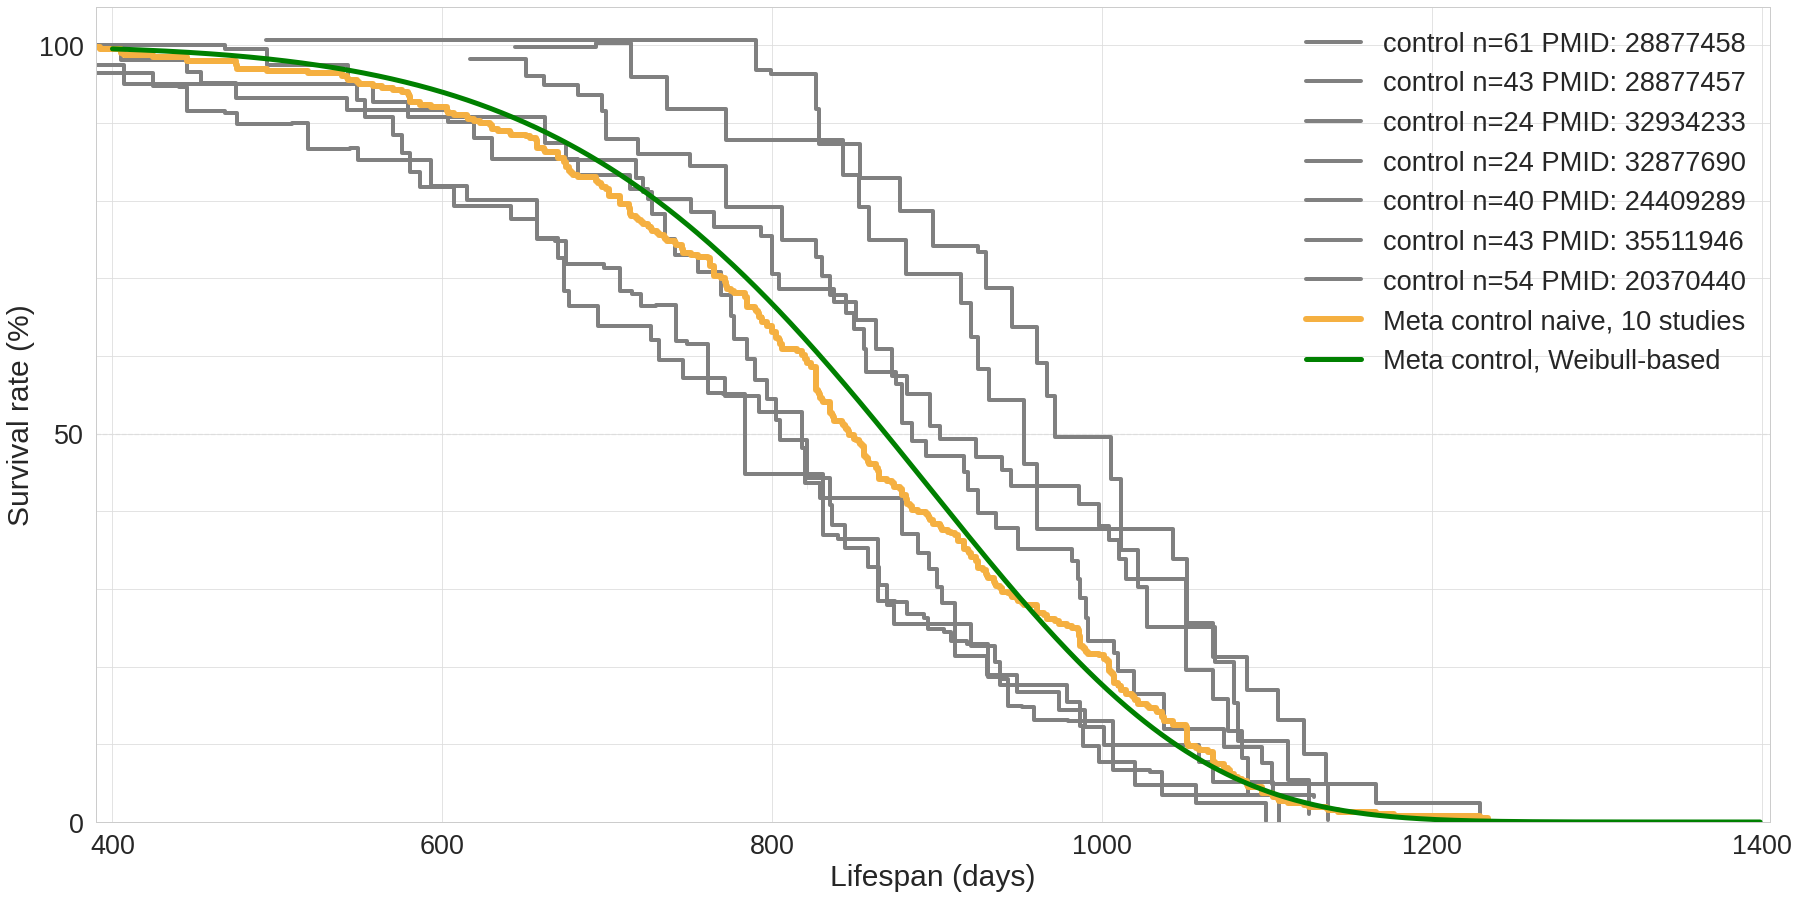

In [21]:
controls = [
            'Curcumin control',
            # 'Berberine control',
            'Sirtuin control',
            'Rapamycin control',
            'Keto control',
            'Rapamycin2 control',
            'Diet control',
            'AKG control',
            'Frailty control',
            'Chinese control',
            'Circad control'
            ]

coef_stat = pd.DataFrame(columns=['lmb', 'rho', 'lmb_V', 'rho_V'])
times_sep = []
times = []
for i, (name, experiment) in enumerate(data.items()):
    if name not in controls:
        continue
    x = experiment['x']
    y = experiment['y']
    n = experiment['n']
    T = convert_to_lifetimes(x, y, n) 
    times += T
    times_sep.append(T)

    wf = WeibullFitter().fit(T)
    lmb, rho = wf.summary.iloc[0, 0], wf.summary.iloc[1, 0]
    lmb_se, rho_se = wf.summary.iloc[0, 1], wf.summary.iloc[1, 1]
    coef_stat = coef_stat.append({'lmb':lmb, 'rho':rho, 'lmb_V':lmb_se**2, 'rho_V':rho_se**2}, ignore_index=True)

km = KaplanMeierFitter().fit(times,)
table = km.event_table
table = table.reset_index()
table['y'] = table['at_risk'] / table['at_risk'].iloc[0] * 100

print('Median surv time =', km.median_survival_time_)

# with sns.axes_style("whitegrid"):
with sns.axes_style("whitegrid", {"grid.color" : "#ddd"}):
    fig, ax = prepare_plot(title='')
    ax.margins(y=-0.004)
    plt.xlim([390, 1405])
    plt.ylim(bottom=90, top=105)
    ax.set_yticks(np.arange(0, 101, 10))
    ax.tick_params(axis='both', which='major', labelsize=27)

    for i in np.arange(4):
        ax.yaxis.get_ticklabels()[1].set_visible(False)
    for i in np.arange(4):
        ax.yaxis.get_ticklabels()[2].set_visible(False)
    
    mcolor = '#F5B041'
    ccolor = 'grey'
    p = round(plausibility_pipe(data['Keto control']), 2)
    ax = sns.lineplot(data=data['Keto control'], y='y', x='x', color=ccolor, label= 'control n=61 PMID: 28877458', drawstyle='steps-post', linewidth = 4)         # +

    p = round(plausibility_pipe(data['Diet control']), 2)
    ax3 = sns.lineplot(data=data['Diet control'], y='y', x='x', color=ccolor, label= 'control n=43 PMID: 28877457', drawstyle='steps-post', linewidth = 4)         # +

    p = round(plausibility_pipe(data['Frailty control']), 2)
    ax4 = sns.lineplot(data=data['Frailty control'], y='y', x='x', color=ccolor, label= 'control n=24 PMID: 32934233', drawstyle='steps-post', linewidth = 4)       # 

    p = round(plausibility_pipe(data['AKG control']), 2)
    ax5 = sns.lineplot(data=data['AKG control'], y='y', x='x', color=ccolor, label= 'control n=24 PMID: 32877690', drawstyle='steps-post', linewidth = 4)                   # 

    p = round(plausibility_pipe(data['Rapamycin2 control']), 2)
    ax6 = sns.lineplot(data=data['Rapamycin2 control'], y='y', x='x', color=ccolor, label= 'control n=40 PMID: 24409289', drawstyle='steps-post', linewidth = 4)        # 

    p = round(plausibility_pipe(data['Circad control']), 2)
    ax7 = sns.lineplot(data=data['Circad control'], y='y', x='x', color=ccolor, label= 'control n=43 PMID: 35511946', drawstyle='steps-post', linewidth = 4)                # +

    p = round(plausibility_pipe(data['Chinese control']), 2)
    ax8 = sns.lineplot(data=data['Chinese control'], y='y', x='x', color=ccolor, label= 'control n=54 PMID: 20370440', drawstyle='steps-post', linewidth = 4)               # +

    ### NAIVE ESTIMATOR ###
    sns.lineplot(data=table, x='event_at', y='y', color=mcolor, label=f'Meta control naive, {len(controls)} studies', drawstyle='steps-post', linewidth = 6)
    
    ### META REGRESSION ###
    from pymare import meta_regression
    lmb_mres = meta_regression(coef_stat['lmb'], coef_stat['lmb_V'])
    rho_mres = meta_regression(coef_stat['rho'], coef_stat['rho_V'])

    l, k = lmb_mres.to_df()['estimate'].item(), rho_mres.to_df()['estimate'].item()
    target_cdf = lambda x: 1 - np.exp(-(x / l)**k)
    x_wf = np.arange(400, 1400)

    sns.lineplot(x_wf, (1 - target_cdf(x_wf)) * 100, lw=5, label='Meta control, Weibull-based', color='g')
    

# спасибо .. замечания по картинке. 
# + 1. наверное не надо на главной картинке помечать контроли отдельно, не о них речь идет. 
# +    Давайте сделаем две картинки, одну в Supplement где отрисованы "серые контроли контролей" каждый своим цветом или штрихом и помечены PMID. 
# +    А в Этой главной и единственой картинке пометим все их серым одинаково.  Серы если можно потемнее ...  и просто обзовем их "extra control" пока. 
# + 2. не надо начинать Lifespan с Нуля. мертвое пространство на графике. можно где то с 500 (?) дней. 
# 3. по оси Y сличком много меток и мелковато, важно чтоб был 100%,  50%  и 0%. 
# 4. количество мышей можно тоже оставить для подписи к картинке, легенду хочу сделать короткую и крупно хорошо видную.  
# 5.  как то я не обращал внимание раньше на ступенку в Рапамицине, и в контролях и в красной ... у нас по этим мышам только одна статья с рапомицином ? как то мало там зверей ... 17 + 18.   Ну если нет больше будем с этими двигаться. 
# 6. дозу тоже можно оставить для подписи и убрать из легенды.   Может  все что надо в легенде это " + SIRT6, - SIRT6, + barb, - barb, + rapa, - rapa, extras"

In [29]:
coef_stat.to_csv('data/coef_stat.csv')

In [23]:
rho_mres.to_df()

,name,estimate,se,z-score,p-value,ci_0.025,ci_0.975
0,intercept,6.518376,0.373338,17.459711,0.0,5.786647,7.250105


In [24]:
lmb_mres.to_df()

,name,estimate,se,z-score,p-value,ci_0.025,ci_0.975
0,intercept,919.109836,22.813684,40.287656,0.0,874.395837,963.823834


In [25]:
import ot

In [26]:

n = 15
x = np.linspace(300, 1400, n+1)
A = np.asarray([np.histogram(t, bins=x,)[0] for t in times_sep]).T

# for i in np.arange(A.shape[1]):
#     plt.plot(A[:, i])

M = ot.utils.dist0(n)
M /= M.max()

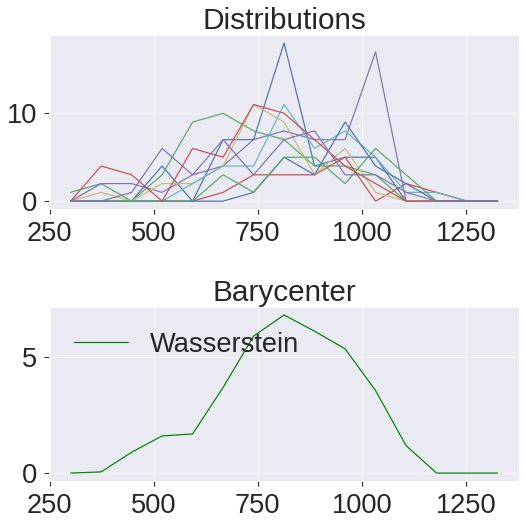

In [27]:
# wasserstein
weights = np.ones(A.shape[1]) * 1 / A.shape[1]
reg = 1e-3
alpha = 0.1

bary_wass = ot.unbalanced.barycenter_unbalanced(A, M, reg, alpha, weights=weights)

import matplotlib.pylab as pl
pl.figure(2, figsize=(8, 8))
pl.clf()
pl.subplot(2, 1, 1)
for i in np.arange(A.shape[1]):
    pl.plot(x[:-1], A[:, i])
pl.title('Distributions')

pl.subplot(2, 1, 2)
pl.plot(x[:-1], bary_wass, 'g', label='Wasserstein')
pl.legend()
pl.title('Barycenter')
pl.tight_layout()